### 1. Importing packages

In [1]:
# !pip install split-folders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# checking gpu support
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate

In [6]:
# import splitfolders
import os
import numpy as np
import pandas as pd
import random

### 2. Loading dataset

In [7]:
# defining constants
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 50

In [8]:
# project's main directory
prj_dir = '/content/drive/MyDrive/TomatoAI'

In [9]:
# building tf input data pipeline
ds = tf.keras.utils.image_dataset_from_directory(
    f'{prj_dir}/tomato-images',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

Found 2225 files belonging to 8 classes.


In [10]:
# getting class names
class_names = ds.class_names
class_names

['Bacterial-Spot',
 'Early-Blight',
 'Healthy',
 'Late-Blight',
 'Leaf-Mold',
 'Mosaic-Virus',
 'Septoria-Leaf-Spot',
 'Target-Spot']

Batch 1 Imgs shape: (32, 256, 256, 3)
Batch 1 Lbls: [6 1 3 1 3 0 0 3 3 1 0 6 1 1 0 0 7 4 3 2 2 6 2 6 3 3 1 4 7 7 7 7]


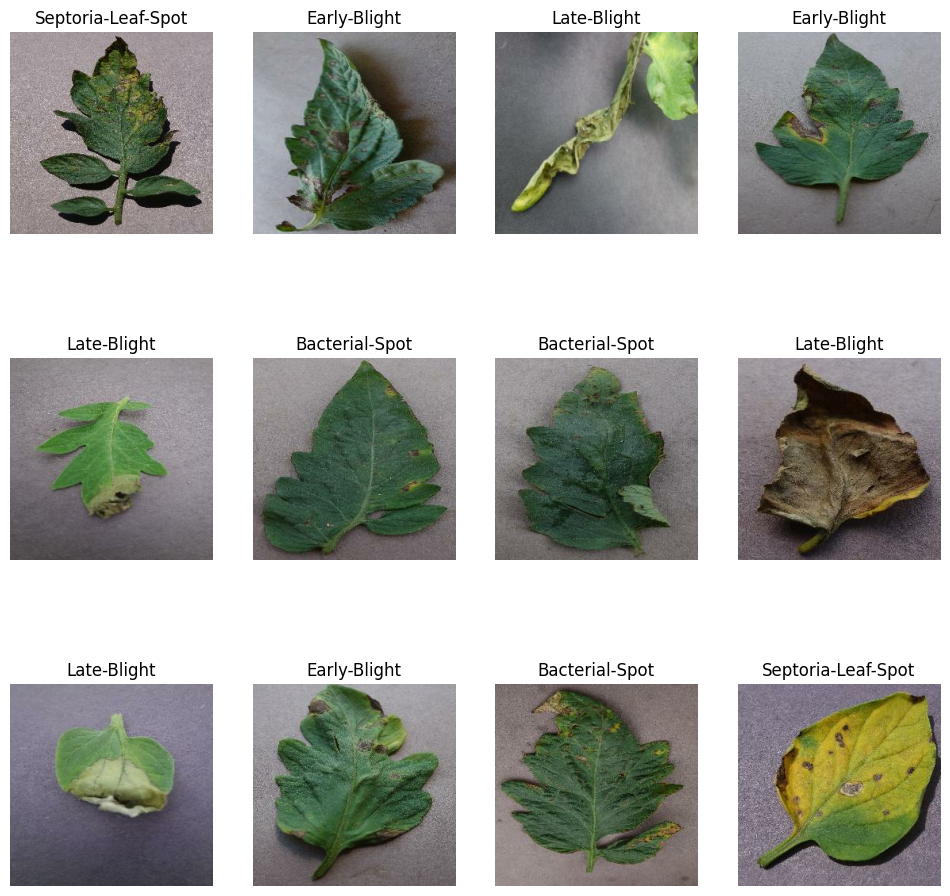

In [11]:
# displaying sample data
img = None

plt.figure(figsize=(12, 12))

for imgs, lbls in ds.take(1):
    print(f'Batch 1 Imgs shape: {imgs.shape}')
    print(f'Batch 1 Lbls: {lbls.numpy()}')

    img = imgs[0].numpy().astype('uint8') # taking sample image

    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')

### 3. Data preprocessing

In [12]:
# creating training set, validation set and testing set
ds_size = len(ds)

ds = ds.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 70
Train set size : 50
Val set size   : 12
Test set size  : 8


In [13]:
# optimizing tf input data pipeline performance

# caching for epochs
# prefetching tf-determined data into CPU as GPU computes - AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# resizing and rescaling layers
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE), # during prediction
    layers.experimental.preprocessing.Rescaling(1.0 / 255) # rescaling rgb values to between 0.0 and 1.0
])

In [15]:
# data augmentation to make model robust and prevent overfitting
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

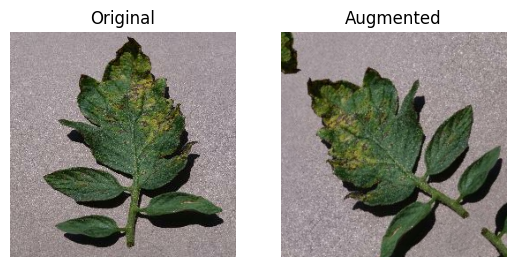

In [16]:
# testing data augmentation
imgs = [img, data_aug(img).numpy().astype('uint8')]
titles = ['Original', 'Augmented']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.axis('off')

In [17]:
# applying data augmentation to training set
train_set = train_set.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# splitfolders.ratio(f'{prj_dir}/Data',
#                    output=f'{prj_dir}/Subsets',
#                    ratio=(.72, .18, .10)
#                    )

In [19]:
# train_imgs_gen = ImageDataGenerator(
#     rescale=1.0 / 255,
#     horizontal_flip=True,
#     vertical_flip=True,
#     rotation_range=20
# )

# train_data_gen = train_imgs_gen.flow_from_directory(
#     f'{prj_dir}/Subsets/train',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='sparse', # integer labels
#     # save_to_dir=f'{prj_dir}/Subsets/aug_train'
# )

# same for validation and testing sets

In [20]:
# for imgs, lbls in train_data_gen:
#     print(imgs.shape)
#     break

### 4. Model building

In [21]:
# building model with alternating Conv2D and MaxPooling2D layers
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3) # 3 channels - rgb
n_classes = len(class_names)

model = models.Sequential([
    resize_rescale, # layers.InputLayer(input_shape=input_shape) # using data generator
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=n_classes, activation='softmax')
])

In [22]:
model.build(input_shape=input_shape)

In [23]:
model.summary() # all trainable parameters -> no transfer learning

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
# compiling model with optimizer, loss and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### 5. Model fitting

In [25]:
train_dir = f'{prj_dir}/Training' # training directory

In [26]:
train_ver = len(os.listdir(train_dir)) # latest saved training
print(f'Latest saved training ver: {train_ver}')

Latest saved training ver: 0


In [27]:
cps_dir = 'training-1/cp-{epoch:04d}.weights' # checkpoints directory

In [29]:
# callback to save model's weights at every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cps_dir,
    verbose=1,
    save_weights_only=True
)

# saving weights
model.save_weights(cps_dir.format(epoch=0))

# fitting model
history = model.fit( # using data generator
    train_set, # train_data_gen
    epochs=EPOCHS, # , steps_per_epoch=train_imgs / BATCH_SIZE
    batch_size=BATCH_SIZE,
    callbacks=[cp_callback],
    validation_data=val_set, # validation_data=val_data_gen, validation_steps=val_imgs / BATCH_SIZE
    verbose=1
)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9125
Epoch 1: saving model to training-1/cp-0001.weights
50/50 [==============================] - 15s 294ms/step - loss: 0.2523 - accuracy: 0.9125 - val_loss: 0.8383 - val_accuracy: 0.7760
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9062
Epoch 2: saving model to training-1/cp-0002.weights
50/50 [==============================] - 14s 284ms/step - loss: 0.2541 - accuracy: 0.9062 - val_loss: 0.9868 - val_accuracy: 0.7344
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.8869
Epoch 3: saving model to training-1/cp-0003.weights
50/50 [==============================] - 14s 285ms/step - loss: 0.2896 - accuracy: 0.8869 - val_loss: 1.2512 - val_accuracy: 0.6667
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.8938
Epoch 4: saving model to training-1/cp-0004.weights
50/50 [=============

In [30]:
# copying checkpoints to Drive
!cp -r training-1 '{prj_dir}/Training'

In [31]:
# getting metrics at every epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

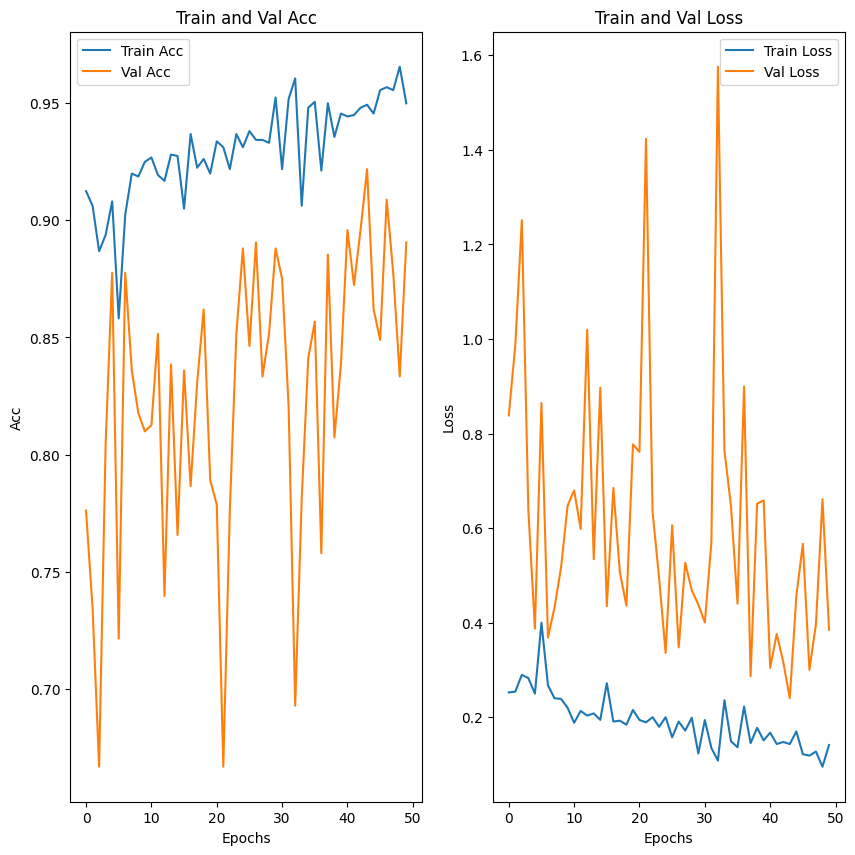

In [32]:
# plotting metrics at every epoch
train_metrics = [train_acc, train_loss]
val_metrics = [val_acc, val_loss]
metrics = ['Acc', 'Loss']

plt.figure(figsize=(10, 10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(EPOCHS), train_metrics[i], label=f'Train {metrics[i]}')
    plt.plot(range(EPOCHS), val_metrics[i], label=f'Val {metrics[i]}')
    plt.xlabel('Epochs')
    plt.ylabel(metrics[i])
    plt.title(f'Train and Val {metrics[i]}')
    plt.legend()

In [33]:
models_dir = f'{prj_dir}/Models' # models directory
# loading model if saved model is available
# model = models.load_model(f'{models_dir}/2')

In [ ]:
# loading weights if saved training is available
# cps_dir = f'{train_dir}/training-1/'

# latest_cp = tf.train.latest_checkpoint(os.path.dirname(cps_dir))
# model.load_weights(latest_cp) # latest weights

# model.load_weights(f'{cps_dir}cp-0044.wights') # best weights

### 6. Model evaluation

In [34]:
# evaluating model using testing set
metrics = model.evaluate(test_set)
print(f'Loss : {round(100 * metrics[0], 2)}%')
print(f'Acc  : {round(100 * metrics[1], 2)}%')

8/8 [==============================] - 6s 27ms/step - loss: 0.3894 - accuracy: 0.8945
Loss : 38.94%
Acc  : 89.45%


In [35]:
# predicting labels of testing set and getting their confidences
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_set.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 [==============================] - 0s 30ms/step


In [36]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [37]:
# getting confusion matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[51  0  0  0  0  0  0  2]
 [ 0 22  1  3  0  0  0  1]
 [ 0  0 37  0  0  0  0  0]
 [ 0  0  0 40  1  1  0  0]
 [ 0  0  2  0 26  0  3  0]
 [ 0  0  0  0  0 14  0  0]
 [ 0  1  2  2  0  0 16  3]
 [ 0  0  9  0  1  0  0 18]]


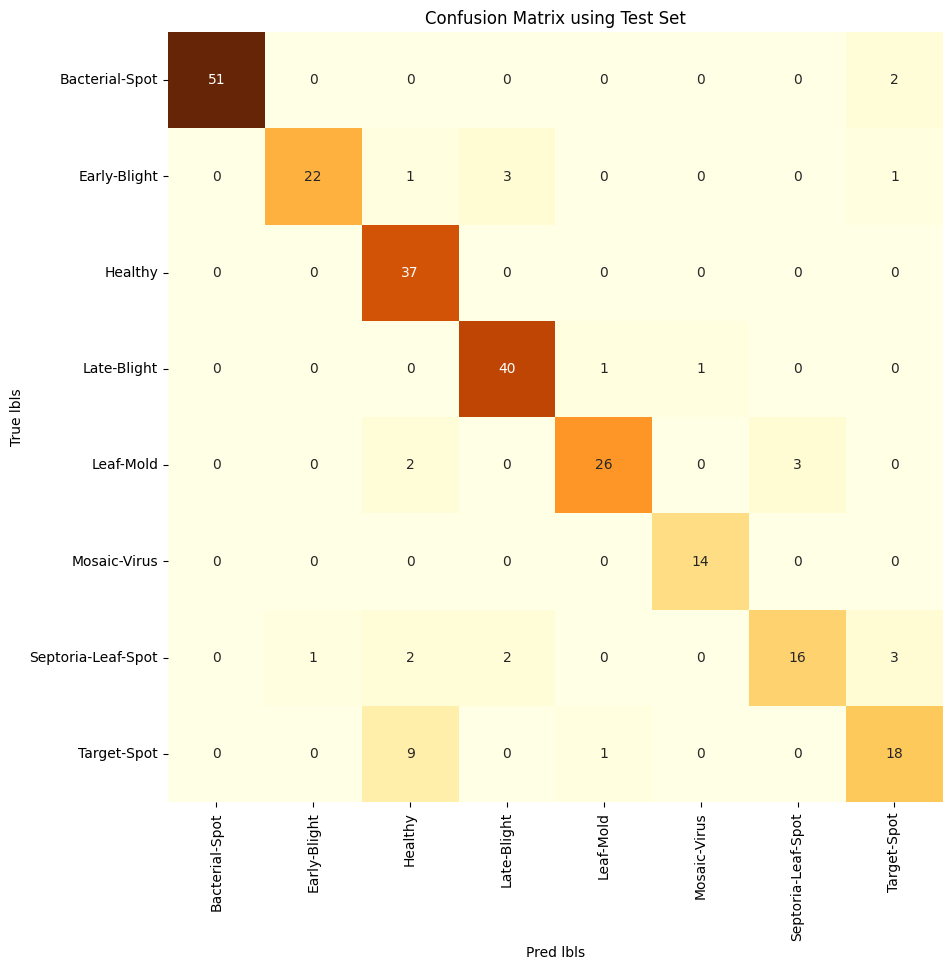

In [38]:
# plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()

In [39]:
# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [40]:
# displaying testing set counts
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+--------------------+-----+
| Bacterial-Spot     |  53 |
+--------------------+-----+
| Early-Blight       |  27 |
+--------------------+-----+
| Healthy            |  37 |
+--------------------+-----+
| Late-Blight        |  42 |
+--------------------+-----+
| Leaf-Mold          |  31 |
+--------------------+-----+
| Mosaic-Virus       |  14 |
+--------------------+-----+
| Septoria-Leaf-Spot |  24 |
+--------------------+-----+
| Target-Spot        |  28 |
+--------------------+-----+
| Test set           | 256 |
+--------------------+-----+


In [41]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s},
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
Bacterial-Spot,100.00%,96.23%,98.08%
Early-Blight,95.65%,81.48%,88.00%
Healthy,72.55%,100.00%,84.09%
Late-Blight,88.89%,95.24%,91.95%
Leaf-Mold,92.86%,83.87%,88.14%
Mosaic-Virus,93.33%,100.00%,96.55%
Septoria-Leaf-Spot,84.21%,66.67%,74.42%
Target-Spot,75.00%,64.29%,69.23%


In [42]:
macro_f1 = round(evals_df['F1'].mean() * 100, 2)
micro_f1 = round(np.sum(cf_matrix.diagonal()) / np.sum(cf_matrix) * 100, 2)
print(f'Macro F1: {macro_f1}%')
print(f'Micro F1: {micro_f1}%')

Macro F1: 86.31%
Micro F1: 87.5%


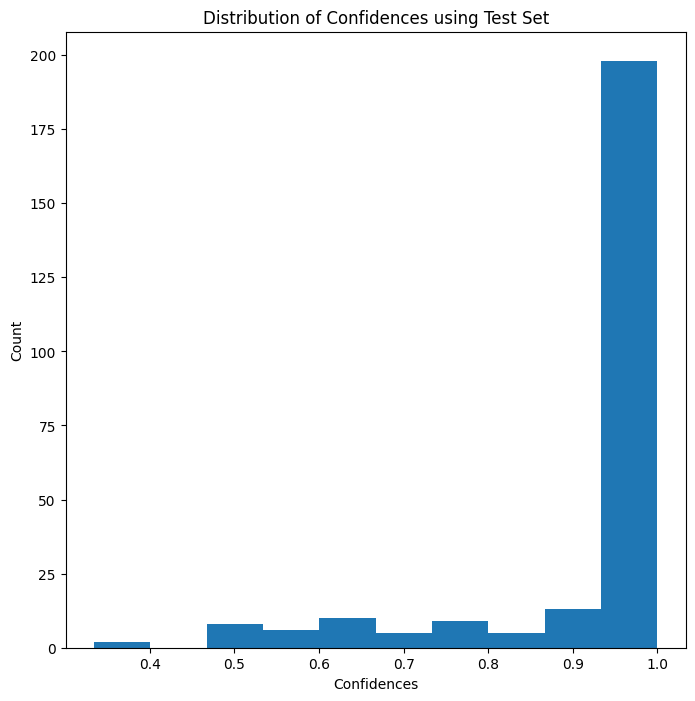

In [43]:
# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

True lbl : Bacterial-Spot
Pred lbl : Bacterial-Spot
Conf     : 99.94%


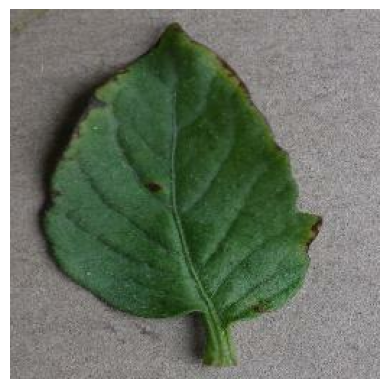

In [44]:
# displaying random image results
rand_batch = random.randint(1, test_size)
rand_img = random.randint(0, BATCH_SIZE - 1)

i = (rand_batch - 1) * BATCH_SIZE
lbl_true_name = lbls_true_names[i:i + BATCH_SIZE][rand_img]
lbl_pred_name = lbls_pred_names[i:i + BATCH_SIZE][rand_img]
pred_conf = pred_confs[i:i + BATCH_SIZE][rand_img]

print(f'True lbl : {lbl_true_name}')
print(f'Pred lbl : {lbl_pred_name}')
print(f'Conf     : {round(100 * pred_conf, 2)}%')

for imgs, lbls in test_set.take(rand_batch):
    plt.imshow(imgs[rand_img].numpy().astype('uint8'))
    plt.axis('off')
    break

### 7. Saving model

In [45]:
# saving latest model
model_ver = len(os.listdir(models_dir)) # latest saved model
model_ver += 1
# model.save(f'{models_dir}/{model_ver}')
model.save(f'{models_dir}/tomato_lens_model_{model_ver}.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# model.save(f'{models_dir}/tomato-disease-detection-model.h5')